In [28]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # turn off automatic numpy parallelization

import numpy as np
import emcee
import corner
import time
from astropy import constants as const
from astropy import units as u
from multiprocessing import Pool
from multiprocessing import cpu_count
from matplotlib import pyplot as plt

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

from load_mcxc_data import load_clusters
from statistics_functions import log_lik_eq



8 CPUs


In [2]:
clusters, variances=load_clusters(nrows=10)

In [15]:
T_data = [c.baryon_temp for c in clusters]

In [10]:
log_mp = np.log10(const.m_p.to(u.GeV, equivalencies=u.mass_energy()).value)

ndim, nwalkers = 2, 32
p0=np.zeros((nwalkers, ndim ))
log_sigma0 = np.random.uniform(low=-30, high=-15, size=nwalkers).astype(np.float128)
log_mx = np.random.uniform(low=-2, high=log_mp, size=nwalkers).astype(np.float128)
p0[:,0]=log_sigma0
p0[:,1]=log_mx
p0

array([[-26.30806439,  -0.4354374 ],
       [-25.45730139,  -1.34639955],
       [-23.03470376,  -0.79825114],
       [-23.37915421,  -0.69119905],
       [-29.69892948,  -0.21776499],
       [-21.5645749 ,  -1.86203227],
       [-22.55570065,  -1.34210191],
       [-24.94896585,  -1.98043966],
       [-29.48006589,  -1.65527864],
       [-27.66951303,  -0.48270414],
       [-21.94736499,  -0.22143425],
       [-18.04130256,  -0.46954678],
       [-22.19700793,  -0.68221726],
       [-27.99528031,  -0.22415353],
       [-15.57898028,  -0.06338406],
       [-20.16385247,  -0.79814053],
       [-17.10743994,  -1.61968641],
       [-26.76448769,  -1.97697344],
       [-28.3914699 ,  -0.26375056],
       [-23.74659085,  -0.18322319],
       [-16.16130096,  -0.59789705],
       [-23.20286451,  -0.7965666 ],
       [-24.85009822,  -1.37438102],
       [-25.7604312 ,  -0.2030572 ],
       [-25.00239743,  -0.72848583],
       [-15.46872154,  -1.99102577],
       [-29.25303925,  -0.7676126 ],
 

In [16]:
# serial
nsteps=100
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_lik_eq, args=[T_data, variances, clusters])
start=time.time()
sampler.run_mcmc(p0, nsteps, progress=True)
end = time.time()
serial_time = end - start
print("Serial took {0:.1f} seconds".format(serial_time))

100%|█████████████████████████████████████████| 100/100 [12:06<00:00,  7.27s/it]

Serial took 734.8 seconds


In [17]:
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_lik_eq, pool=pool, args=[T_data, variances, clusters])
    start = time.time()
    sampler.run_mcmc(p0, nsteps, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print("{0:.1f} times faster than serial".format(serial_time / multi_time))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


100%|█████████████████████████████████████████| 100/100 [04:00<00:00,  2.40s/it]

Multiprocessing took 246.2 seconds
3.0 times faster than serial


In [40]:
nsteps=15000

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_lik_eq, pool=pool, args=[T_data, variances, clusters])
    sampler.run_mcmc(p0, nsteps, progress=True)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


100%|██████████████████████████████████| 15000/15000 [11:23:41<00:00,  2.73s/it]


In [39]:
nsteps_additional=5000
pool.close()
pool.join()
# start as None instead of flat_samples[:-1] if I have run previously
with Pool() as pool:
    sampler.run_mcmc(None, nsteps_additional, progress=True)

ValueError: incompatible input dimensions (319999, 2)

In [47]:
print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

Mean autocorrelation time: 208.260 steps


In [48]:
"Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction))

'Mean acceptance fraction: 0.483'

(480000, 2)


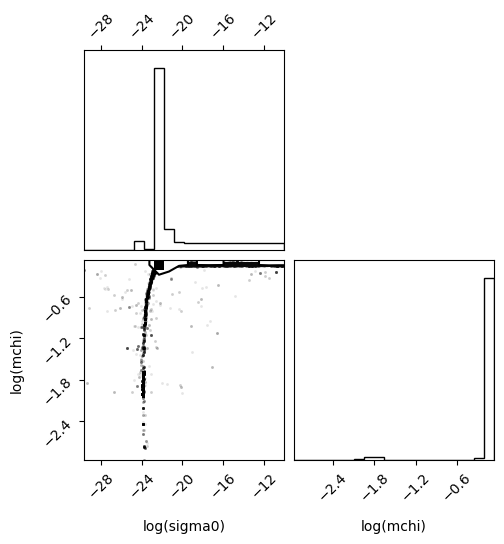

In [49]:
flat_samples = sampler.get_chain(flat=True) #discard=
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=['log(sigma0)', 'log(mchi)'], top_ticks=True)

In [44]:
np.median(flat_samples[:,0])

-22.18301771093985

In [45]:
np.median(flat_samples[:,1])

-0.1502399556573126

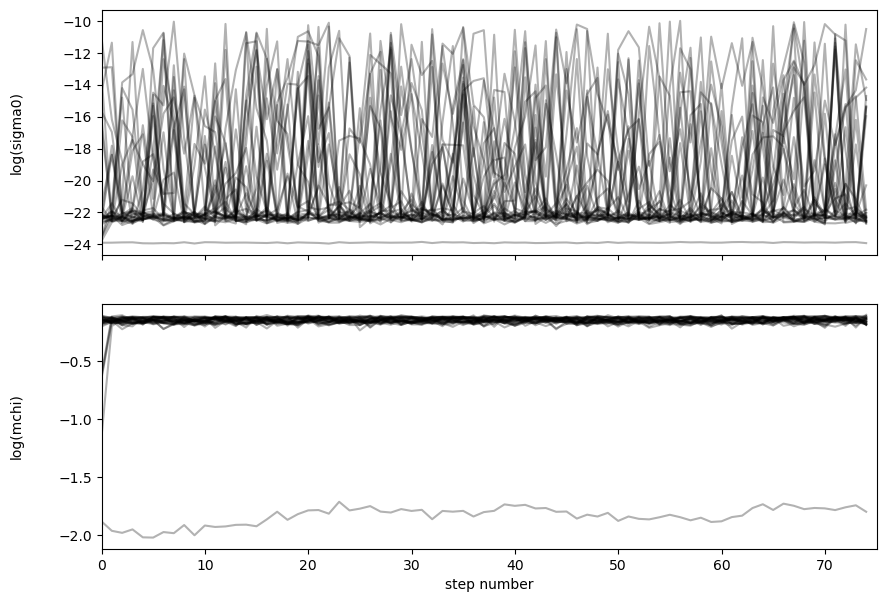

In [46]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(thin=200)
labels = ['log(sigma0)', 'log(mchi)']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

array([[-26.00456646,  -0.63089286],
       [-25.45730139,  -1.34639955],
       [-23.03470376,  -0.79825114],
       ...,
       [-16.36094488,  -0.12170304],
       [-20.02881254,  -0.13180073],
       [-22.48499566,  -0.1702158 ]])